# Produce table with all collected metrics for all available configurations

In [2]:
import pandas as pd
import os
import cPickle as pickle
import matplotlib.pylab as plt
from collections import defaultdict
import re
import numpy as np
from thesis.utils.metrics import *

In [73]:
# ROOT_RESULTS_LOCATION = '/mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/'
ROOT_RESULTS_LOCATION = '/mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/'
# ROOT_RESULTS_LOCATION = '/mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/'
CLASSIFICATION_TYPE = 'sections'
METRICS_PNG_FILE = '{}_validation_metrics.png'
METRICS_PKL_FILE = '{}_validation_metrics.pkl'
DOC2VEC_FILES_PREFIX = 'model'
WORD2VEC_METRICS_FILE = 'word2vec_metrics.pkl'
EPOCH_PREFIX = 'epoch_{}'

DOC2VEC_MAX_EPOCHS = 20

CLASSIFICATION_SEPARATOR = ' ** '

CLASSIFICATION_TYPES_TO_USE = ['sections']
METRICS_TO_USE = ['coverage_error', 'f1_micro', 'f1_macro', 'top_3', 'top_5']
METRICS_BEST_VALUE_FUNC = {'coverage_error': np.min, 'f1_micro': np.max, 'f1_macro': np.max, 'top_3': np.max, 'top_5': np.max}
METRICS_BEST_INDEX_FUNC = {'coverage_error': np.argmin, 'f1_micro': np.argmax, 'f1_macro': np.argmax, 'top_3': np.argmax, 'top_5': np.argmax}

In [74]:
def get_subdirectories(d):
    #return filter(os.path.isdir, [f for f in os.listdir(d)])
    return [f for f in os.listdir(d) if os.path.isdir(os.path.join(d,f))]
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [75]:
get_subdirectories(ROOT_RESULTS_LOCATION)

['doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_4_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_

In [65]:
os.listdir(ROOT_RESULTS_LOCATION)

['doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_4_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_

In [66]:
table_rows = []
table_index = []
for doc2vec_method in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):
    print doc2vec_method
    epochs_path = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_method)
    # this will have the structure dict of classifiers -> dict of metrics -> list of values throughout the epoch
    epoch_metrics = dict()
    epoch_word2vec_results = []
    epochs_trained = 0
    for epoch in natural_sort(get_subdirectories(epochs_path)):
        print epoch
        epochs_trained += 1
        epoch_path =  os.path.join(epochs_path, epoch)
        if os.path.exists(os.path.join(epoch_path, WORD2VEC_METRICS_FILE)):
            method_word2vec_results = pickle.load(open(os.path.join(epoch_path, WORD2VEC_METRICS_FILE), 'r'))
            epoch_word2vec_results.append(method_word2vec_results)
        for classifier in get_subdirectories(epoch_path):
            
            if classifier.startswith('nn'): continue
            # the values of a metric for a specific classifier throughout the epochs
            if not epoch_metrics.get(classifier): epoch_metrics[classifier] = defaultdict(list)
            
            for classf_type in CLASSIFICATION_TYPES_TO_USE:
                classifier_metrics_file = os.path.join(epoch_path, classifier, METRICS_PKL_FILE.format(classf_type))
                if os.path.exists(classifier_metrics_file):
                    classifier_metrics = pickle.load(open(classifier_metrics_file, 'r'))
                    
#                     Fix for adding the y_true, y_score and y_binary_score matrices to the metrics dump which inflated its size
                    if type(classifier_metrics) is list:
                        classifier_metrics = classifier_metrics[-1]
                    if classifier_metrics.get('y_true') is not None:
                        print 'y_true not None'
                        classifier_metrics.pop('y_true', None)
                        classifier_metrics.pop('y_score', None)
                        classifier_metrics.pop('y_binary_score', None)
                        pickle.dump(classifier_metrics, open(classifier_metrics_file, 'w'))
                    
                    # due to a mistake we made, some metrics files contain the whole history of metrics throughout the epochs
                    if type(classifier_metrics) is list:
                        classifier_metrics = classifier_metrics[-1]
                        pickle.dump(classifier_metrics, open(classifier_metrics_file, 'w'))
                    for metric_name in METRICS_TO_USE:
                        metric_full_name = classf_type + CLASSIFICATION_SEPARATOR + metric_name
                        epoch_metrics[classifier][metric_full_name].append(classifier_metrics[metric_name])
                        
    
    total = 0
    word2vec_epoch_correct_results = []
    for res in epoch_word2vec_results:
        total_result = [d for d in res if d['section'] == 'total'][0]
        total_correct = len(total_result['correct'])
        total_incorrect = len(total_result['incorrect'])
        if total == 0: total = total_correct + total_incorrect
        word2vec_epoch_correct_results.append(total_correct)
    best_word2vec_value = np.max(word2vec_epoch_correct_results) if len(word2vec_epoch_correct_results) else np.NaN
    best_word2vec_epoch = np.argmax(word2vec_epoch_correct_results) if len(word2vec_epoch_correct_results) else np.NaN
        
    # now that we are done with our epochs, lets figure out which epoch had the best value of every metric
    for classifier_name in sorted(epoch_metrics.keys()):
        classifier_metrics_dict = defaultdict(float)
        for metric_name in epoch_metrics[classifier_name].keys():
#             best_epoch = np.argmax(epoch_metrics[classifier_name][metric_name])
#             best_value = np.max(epoch_metrics[classifier_name][metric_name])
            just_metric = metric_name.split(CLASSIFICATION_SEPARATOR)[1]
            best_epoch = METRICS_BEST_INDEX_FUNC[just_metric](epoch_metrics[classifier_name][metric_name])
            best_value = METRICS_BEST_VALUE_FUNC[just_metric](epoch_metrics[classifier_name][metric_name])
            metric_range = abs(np.max(epoch_metrics[classifier_name][metric_name]) - np.min(epoch_metrics[classifier_name][metric_name]))
            classifier_metrics_dict[metric_name] = round(best_value, 3)
#             classifier_metrics_dict[metric_name + ' -> epoch'] = best_epoch + 1
#             classifier_metrics_dict[metric_name + ' range'] = round(metric_range, 3)

#         classifier_metrics_dict['word2vec result'] = best_word2vec_value
#         classifier_metrics_dict['word2vec result epoch'] = best_word2vec_epoch
#         classifier_metrics_dict['word2vec result range'] = abs(np.max(word2vec_epoch_correct_results) - np.min(word2vec_epoch_correct_results))
        classifier_metrics_dict['Epochs'] = epochs_trained

        table_rows.append(classifier_metrics_dict)
        table_index.append(doc2vec_method + ' / ' + classifier_name)
        
            
df = pd.DataFrame(data=table_rows, index=table_index)            
df

doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_8
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_7
doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_8
doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
epoch_6
epoch_7
epoch_8
epoch_9
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
epoch_6
epoch_7
epoch_8
epoch_9
epoch_10
epoch_11
epoch_12
epoch_13
epoch_14
epoch_15
epoch_16
epoch_17
epoch_18
doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_4
doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
epoch_6
epoch_7
epoch_8
epoch_9
epoch_10
doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs

,Epochs,subclasses ** coverage_error,subclasses ** f1_macro,subclasses ** f1_micro,subclasses ** top_3,subclasses ** top_5
doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.1_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.01_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.1_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,9,NaN,NaN,NaN,NaN,NaN
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,18,NaN,NaN,NaN,NaN,NaN
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,18,NaN,NaN,NaN,NaN,NaN


In [24]:
df.filter(regex=('.*iter_10_reg_0.001_classweights_None.*'), axis=0)\
.filter(regex='100', axis=0)
# .filter(regex='f1_micro|Epochs', axis=1)

,Epochs,sections ** coverage_error,sections ** f1_macro,sections ** f1_micro,sections ** top_3,sections ** top_5,word2vec result,word2vec result epoch,word2vec result range
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,18,2.007,0.396,0.632,0.870,0.936,2723,17,1527
doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,1,NaN,NaN,NaN,NaN,NaN,2306,0,0
doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,10,2.100,0.349,0.608,0.858,0.919,1626,9,952
doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,7,NaN,NaN,NaN,NaN,NaN,0,0,0
doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_None,6,NaN,NaN,NaN,NaN,NaN,0,0,0


In [12]:
df.loc[:, ['Epochs', 'subclasses ** coverage_error', 'subclasses ** f1_micro', 'subclasses ** f1_macro', 'subclasses ** top_3', 'subclasses ** top_5']]#.sort_values(by='sections ** f1_macro', ascending=False)
# df.loc[:, ['Epochs', 'classes ** coverage_error', 'classes ** f1_micro', 'classes ** f1_macro', 'classes ** top_3', 'classes ** top_5']]#.sort_values(by='sections ** f1_macro', ascending=False)
#df.loc[:, ['Epochs', 'sections ** coverage_error', 'sections ** f1_micro', 'sections ** f1_macro', 'sections ** top_3']]#.sort_values(by='sections ** f1_macro', ascending=False)

,Epochs,subclasses ** coverage_error,subclasses ** f1_micro,subclasses ** f1_macro,subclasses ** top_3,subclasses ** top_5
doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.1_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.01_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.1_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1,NaN,NaN,NaN,NaN,NaN
doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,9,NaN,NaN,NaN,NaN,NaN
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,18,NaN,NaN,NaN,NaN,NaN
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,18,NaN,NaN,NaN,NaN,NaN


In [13]:
df.loc[:,['word2vec result']]

,word2vec result
doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,1168
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,627
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.1_classweights_balanced,627
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,627
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.01_classweights_balanced,627
doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.1_classweights_balanced,627
doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,0
doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.001_classweights_balanced,2390
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,2723
doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,2723


In [14]:
pd.DataFrame([{'dd':2,'ee':3,'ff':4},{'dd':2,'ee':3}], index=['sdfsf','sdlfsdfsdf'])

,dd,ee,ff
sdfsf,2,3,4.0
sdlfsdfsdf,2,3,NaN


## Show Graph for specific configuration

Doc2vec methods

In [26]:
natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION))

['doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'vocab_model']

Classifier Names

In [7]:
classifier_names = set()
for doc2vec_method in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):
    epochs_path = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_method)
    for epoch in natural_sort(get_subdirectories(epochs_path)):
        epoch_path =  os.path.join(epochs_path, epoch)
        for subdirectory in natural_sort(get_subdirectories(epoch_path)):
            if not subdirectory.startswith(EPOCH_PREFIX):
                classifier_names.add(subdirectory)
natural_sort(classifier_names)

['svm_iter_10_reg_0.01_classweights_balanced',
 'svm_iter_10_reg_0.001_classweights_balanced',
 'svm_iter_10_reg_0.01_classweights_None',
 'svm_iter_10_reg_0.001_classweights_None',
 'svm_iter_100_reg_0.001_classweights_balanced',
 'svm_iter_100_reg_0.01_classweights_balanced',
 'svm_iter_100_reg_0.001_classweights_None']

<IPython.core.display.Javascript object>


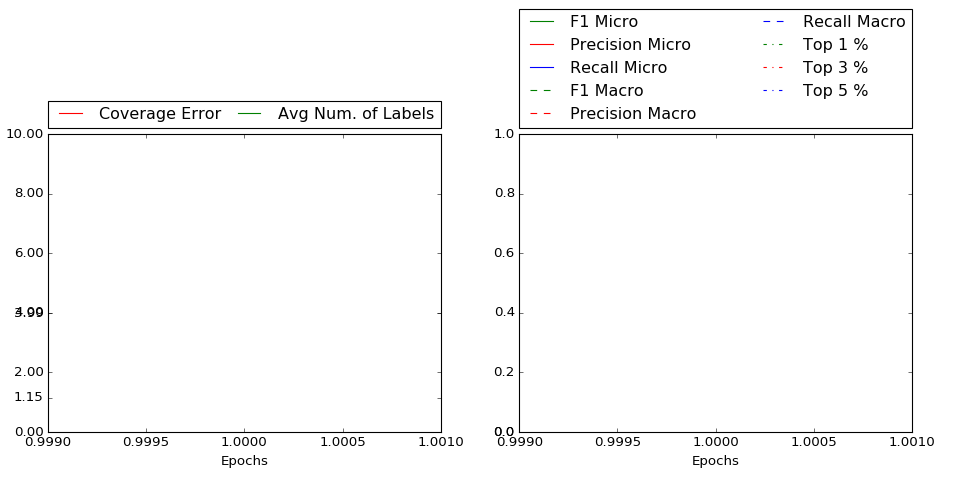

Epoch 01: Coverage Error -> 3.99, F1 Micro -> 0.000, F1 Macro -> 0.000, Top 3 -> 0.531


In [78]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(10)

doc2vec_approach = "doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None"
classifier_approach = "svm_iter_10_reg_0.001_classweights_None"
classification_type = "sections"
for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        metrics_folder = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_approach, EPOCH_PREFIX.format(epoch), classifier_approach)
        #print metrics_folder
        metrics = pickle.load(open(os.path.join(metrics_folder, METRICS_PKL_FILE.format(classification_type))))
        print "Epoch {:02d}: Coverage Error -> {:.2f}, F1 Micro -> {:.3f}, F1 Macro -> {:.3f}, Top 3 -> {:.3f}".format(epoch, metrics['coverage_error'], metrics['f1_micro'], metrics['f1_macro'], metrics['top_3'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        continue

## Visualize Word2vec Results

*************** doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


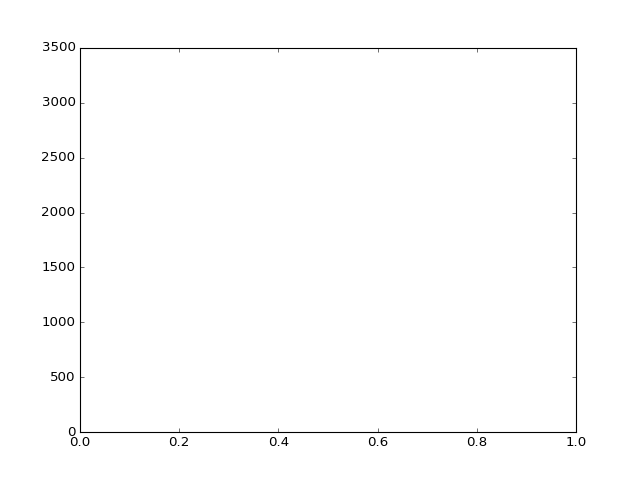

*************** doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


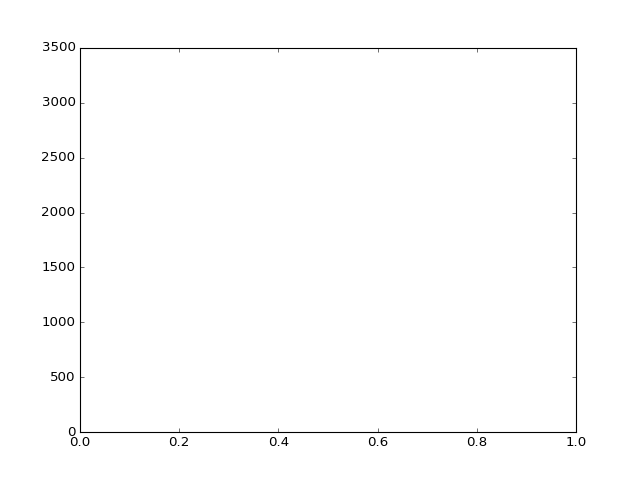

*************** doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


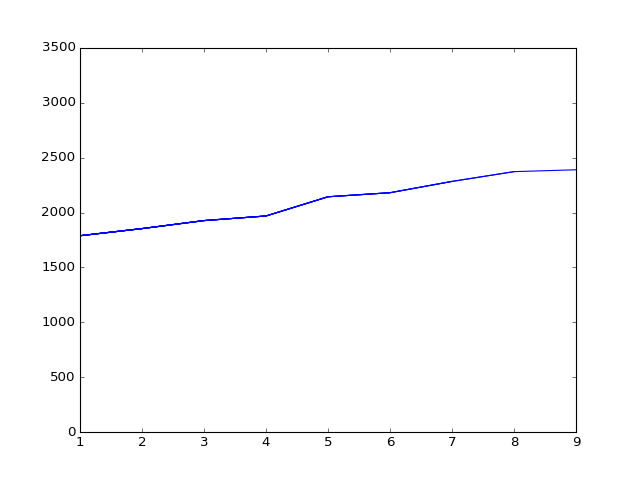

Epoch 01: Word2vec Result -> 1789.00, Syntactic: 1686, Semantic: 103
Epoch 02: Word2vec Result -> 1854.00, Syntactic: 1786, Semantic: 68
Epoch 03: Word2vec Result -> 1927.00, Syntactic: 1846, Semantic: 81
Epoch 04: Word2vec Result -> 1969.00, Syntactic: 1893, Semantic: 76
Epoch 05: Word2vec Result -> 2144.00, Syntactic: 2065, Semantic: 79
Epoch 06: Word2vec Result -> 2181.00, Syntactic: 2092, Semantic: 89
Epoch 07: Word2vec Result -> 2284.00, Syntactic: 2197, Semantic: 87
Epoch 08: Word2vec Result -> 2373.00, Syntactic: 2276, Semantic: 97
Epoch 09: Word2vec Result -> 2390.00, Syntactic: 2307, Semantic: 83
*************** doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


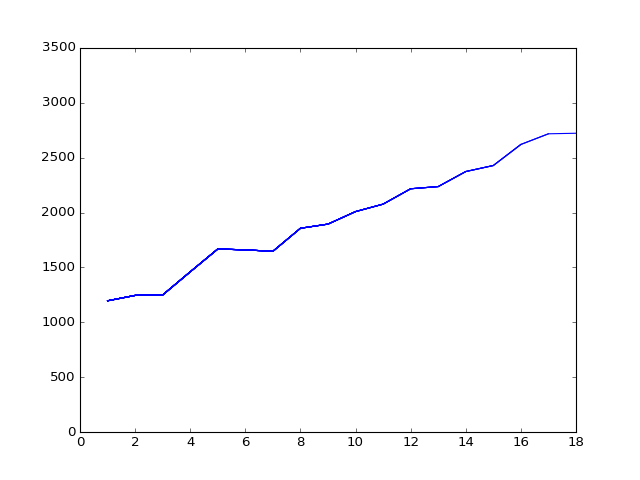

Epoch 01: Word2vec Result -> 1196.00, Syntactic: 1118, Semantic: 78
Epoch 02: Word2vec Result -> 1245.00, Syntactic: 1170, Semantic: 75
Epoch 03: Word2vec Result -> 1249.00, Syntactic: 1190, Semantic: 59
Epoch 04: Word2vec Result -> 1460.00, Syntactic: 1393, Semantic: 67
Epoch 05: Word2vec Result -> 1668.00, Syntactic: 1605, Semantic: 63
Epoch 06: Word2vec Result -> 1660.00, Syntactic: 1577, Semantic: 83
Epoch 07: Word2vec Result -> 1647.00, Syntactic: 1565, Semantic: 82
Epoch 08: Word2vec Result -> 1857.00, Syntactic: 1789, Semantic: 68
Epoch 09: Word2vec Result -> 1895.00, Syntactic: 1822, Semantic: 73
Epoch 10: Word2vec Result -> 2009.00, Syntactic: 1922, Semantic: 87
Epoch 11: Word2vec Result -> 2077.00, Syntactic: 1999, Semantic: 78
Epoch 12: Word2vec Result -> 2217.00, Syntactic: 2121, Semantic: 96
Epoch 13: Word2vec Result -> 2237.00, Syntactic: 2137, Semantic: 100
Epoch 14: Word2vec Result -> 2374.00, Syntactic: 2278, Semantic: 96
Epoch 15: Word2vec Result -> 2429.00, Syntactic

<IPython.core.display.Javascript object>


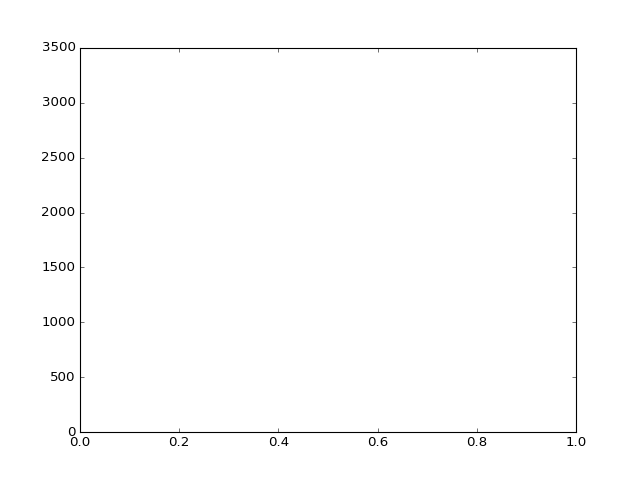

*************** doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


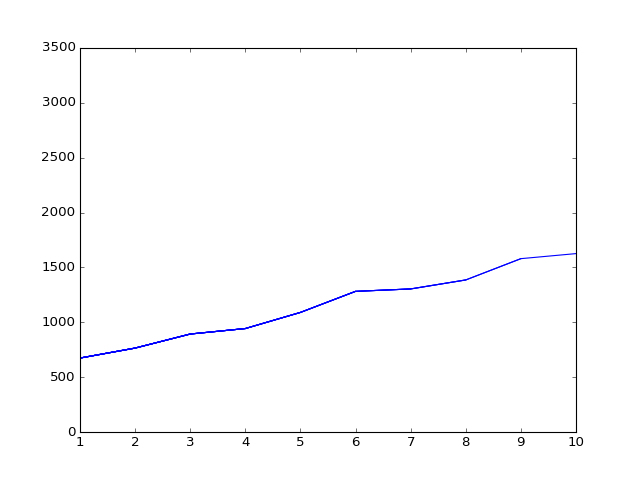

Epoch 01: Word2vec Result -> 674.00, Syntactic: 636, Semantic: 38
Epoch 02: Word2vec Result -> 765.00, Syntactic: 703, Semantic: 62
Epoch 03: Word2vec Result -> 893.00, Syntactic: 841, Semantic: 52
Epoch 04: Word2vec Result -> 943.00, Syntactic: 889, Semantic: 54
Epoch 05: Word2vec Result -> 1090.00, Syntactic: 1044, Semantic: 46
Epoch 06: Word2vec Result -> 1282.00, Syntactic: 1215, Semantic: 67
Epoch 07: Word2vec Result -> 1304.00, Syntactic: 1253, Semantic: 51
Epoch 08: Word2vec Result -> 1386.00, Syntactic: 1320, Semantic: 66
Epoch 09: Word2vec Result -> 1580.00, Syntactic: 1514, Semantic: 66
Epoch 10: Word2vec Result -> 1626.00, Syntactic: 1547, Semantic: 79
*************** doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


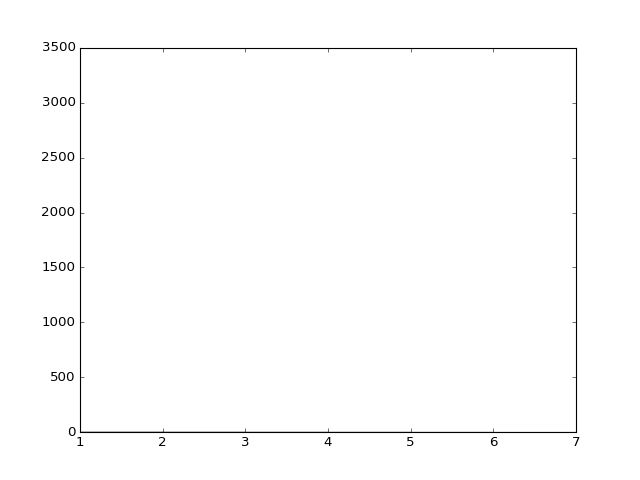

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 07: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


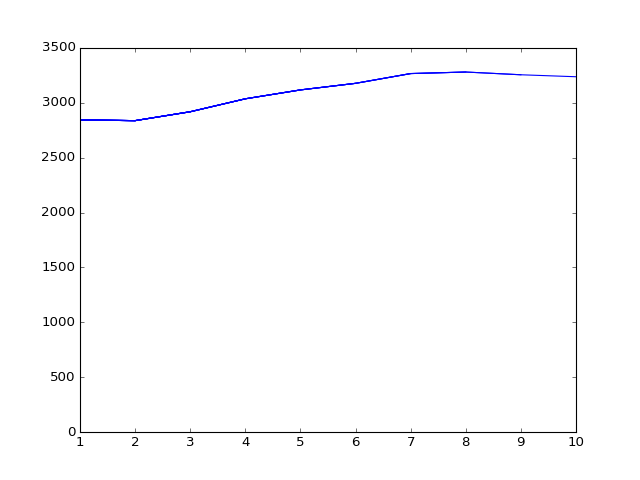

Epoch 01: Word2vec Result -> 2844.00, Syntactic: 2658, Semantic: 186
Epoch 02: Word2vec Result -> 2838.00, Syntactic: 2669, Semantic: 169
Epoch 03: Word2vec Result -> 2919.00, Syntactic: 2752, Semantic: 167
Epoch 04: Word2vec Result -> 3037.00, Syntactic: 2876, Semantic: 161
Epoch 05: Word2vec Result -> 3118.00, Syntactic: 2918, Semantic: 200
Epoch 06: Word2vec Result -> 3178.00, Syntactic: 2998, Semantic: 180
Epoch 07: Word2vec Result -> 3267.00, Syntactic: 3077, Semantic: 190
Epoch 08: Word2vec Result -> 3281.00, Syntactic: 3083, Semantic: 198
Epoch 09: Word2vec Result -> 3256.00, Syntactic: 3035, Semantic: 221
Epoch 10: Word2vec Result -> 3238.00, Syntactic: 3012, Semantic: 226
*************** doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


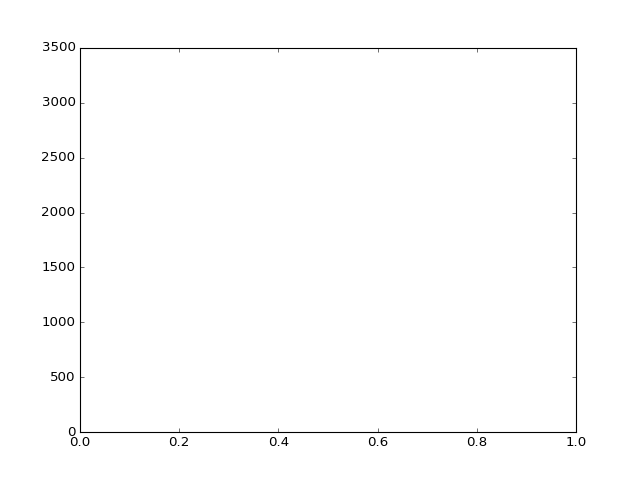

*************** doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


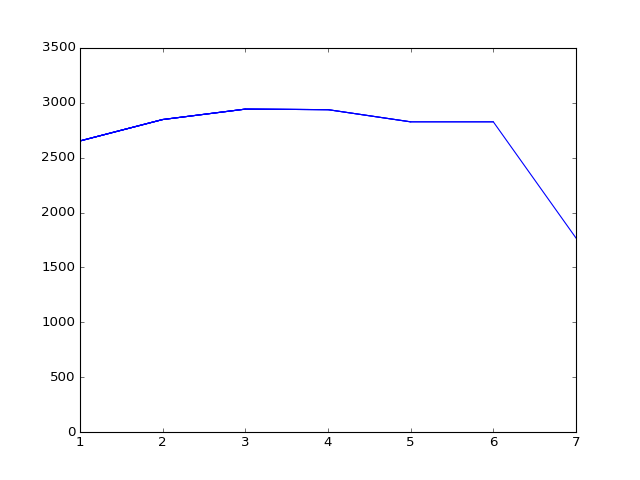

Epoch 01: Word2vec Result -> 2653.00, Syntactic: 2466, Semantic: 187
Epoch 02: Word2vec Result -> 2848.00, Syntactic: 2668, Semantic: 180
Epoch 03: Word2vec Result -> 2943.00, Syntactic: 2758, Semantic: 185
Epoch 04: Word2vec Result -> 2938.00, Syntactic: 2734, Semantic: 204
Epoch 05: Word2vec Result -> 2827.00, Syntactic: 2600, Semantic: 227
Epoch 06: Word2vec Result -> 2827.00, Syntactic: 2600, Semantic: 227
Epoch 07: Word2vec Result -> 1768.00, Syntactic: 1591, Semantic: 177
*************** doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


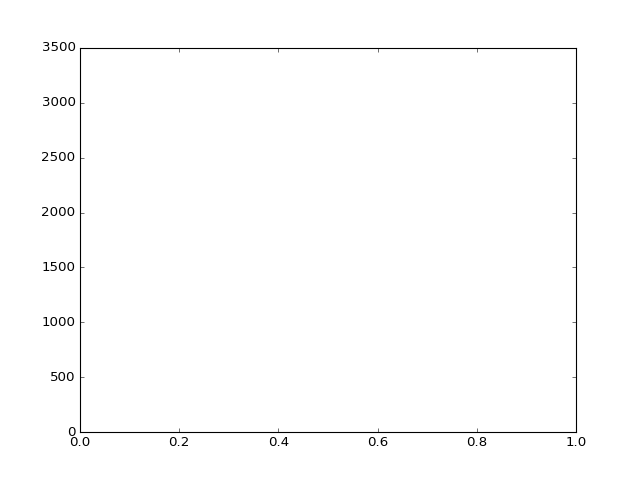

*************** doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


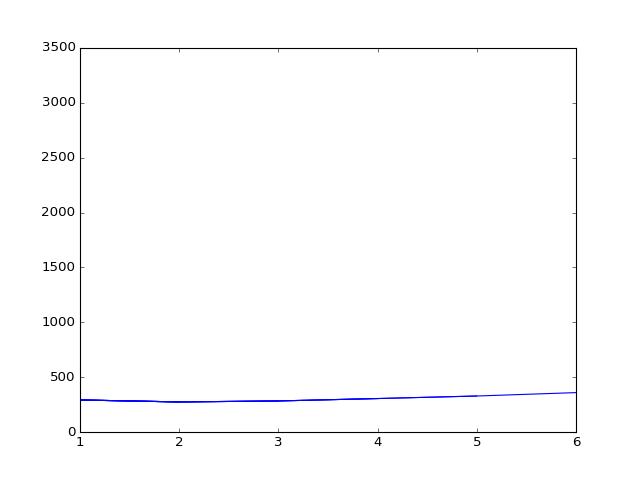

Epoch 01: Word2vec Result -> 292.00, Syntactic: 288, Semantic: 4
Epoch 02: Word2vec Result -> 274.00, Syntactic: 266, Semantic: 8
Epoch 03: Word2vec Result -> 283.00, Syntactic: 273, Semantic: 10
Epoch 04: Word2vec Result -> 305.00, Syntactic: 297, Semantic: 8
Epoch 05: Word2vec Result -> 328.00, Syntactic: 320, Semantic: 8
Epoch 06: Word2vec Result -> 359.00, Syntactic: 350, Semantic: 9
*************** doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None


<IPython.core.display.Javascript object>


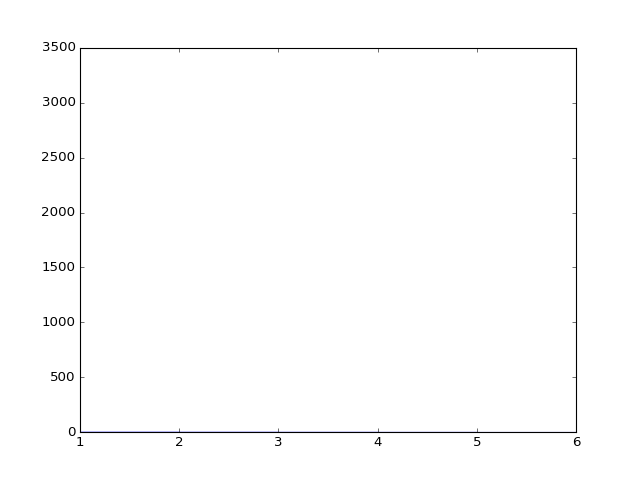

Epoch 01: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 02: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 03: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 04: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 05: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
Epoch 06: Word2vec Result -> 0.00, Syntactic: 0, Semantic: 0
*************** vocab_model


<IPython.core.display.Javascript object>


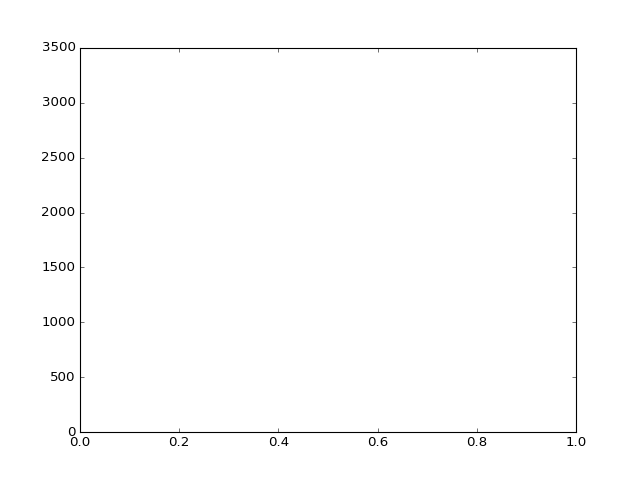

In [43]:
%matplotlib notebook
for doc2vec_approach in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):

    print "*************** {}".format(doc2vec_approach)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_ylim([0,3500])
    word2vec_results = []
    for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
        try:
            method_word2vec_results = pickle.load(open(os.path.join(ROOT_RESULTS_LOCATION, doc2vec_approach, EPOCH_PREFIX.format(epoch), WORD2VEC_METRICS_FILE), 'r'))
            total_result = [d for d in method_word2vec_results if d['section'] == 'total'][0]
            total_correct = len(total_result['correct'])
            word2vec_results.append(total_correct)
            
            syntactic_results = [d for d in method_word2vec_results if d['section'].startswith('gram')]
            semantic_results = [d for d in method_word2vec_results if not d['section'].startswith('gram') and d['section'] != 'total']
            syntactic_total_correct = sum([len(res['correct']) for res in syntactic_results])
            semantic_total_correct = sum([len(res['correct']) for res in semantic_results])
            #print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
            print "Epoch {:02d}: Word2vec Result -> {:.2f}, Syntactic: {}, Semantic: {}".format(epoch, total_correct, syntactic_total_correct, semantic_total_correct)
            ax.plot(range(1,epoch+1), word2vec_results, 'b')
            fig.canvas.draw()
        except IOError:
            break